In [2]:
import dill as pkl
import plotnine as p9
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prismo.downstream import match
import seaborn as sns
from data_loader import load_xenium_breast_cancer
import scanpy as sc
from prismo import PRISMO, DataOptions, TrainingOptions, ModelOptions, SmoothOptions, feature_sets

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-pac

In [27]:
def to_upper(feature_set_collection):
    return feature_sets.FeatureSets(
        [
            feature_sets.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )

# load and preprocess data
data = load_xenium_breast_cancer()
sc.pp.highly_variable_genes(data["group_chromium"]["rna"], subset=True)
data["group_chromium"]["rna"].var_names = (data["group_chromium"]["rna"].var["symbol"].astype(str))
data["group_xenium"]["rna"].var_names = (data["group_xenium"]["rna"].var["symbol"].astype(str))

# load annotations
gene_set_collection = to_upper(feature_sets.from_gmt(
    "../msigdb/h.all.v7.5.1.symbols.gmt", name="hallmark"
))

gene_set_collection = gene_set_collection.filter(
    np.union1d(data["group_chromium"]["rna"].var_names, data["group_xenium"]["rna"].var_names),
    min_fraction=0.2,
    min_count=10,
    max_count=300,
)


In [28]:
len(gene_set_collection.feature_sets)

25

In [33]:
data["group_xenium"]["rna"].varm["gene_set_mask"].sum(axis=1)

ABCC11    0
ACTA2     1
ACTG2     1
ADAM9     3
ADGRE5    0
         ..
VWF       2
WARS      0
ZEB1      1
ZEB2      0
ZNF562    0
Length: 313, dtype: int64

In [2]:
data = load_xenium_breast_cancer()
sc.pp.highly_variable_genes(data["group_chromium"]["rna"], subset=True)
data["group_chromium"]["rna"].var_names = (data["group_chromium"]["rna"].var["symbol"].astype(str))
data["group_xenium"]["rna"].var_names = (data["group_xenium"]["rna"].var["symbol"].astype(str))
data['group_xenium']['rna'] = data['group_xenium']['rna'][data['group_xenium']['rna'].obs.index.argsort()]

In [5]:
cache_3CA = pkl.load(open("3CA_0/cache.pkl", "rb"))
cache_hallmark = pkl.load(open("hallmark_0/cache.pkl", "rb"))
cache_uninformed = pkl.load(open("uninformed_1/cache.pkl", "rb"))

## Loss curves

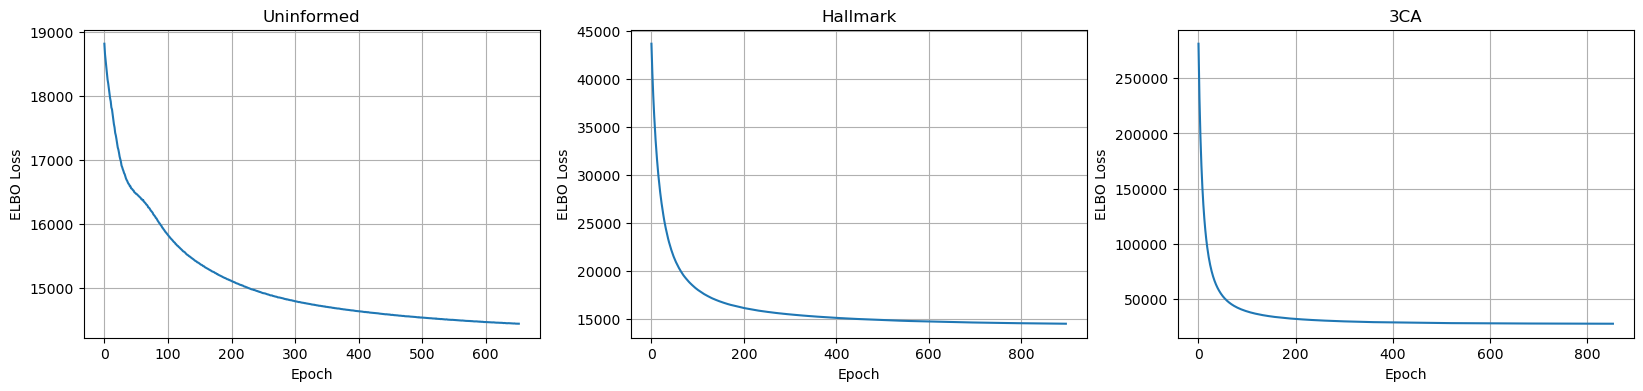

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

axs[0].plot(range(len(cache_uninformed["train_loss_elbo"])), cache_uninformed["train_loss_elbo"])
axs[1].plot(range(len(cache_hallmark["train_loss_elbo"])), cache_hallmark["train_loss_elbo"])
axs[2].plot(range(len(cache_3CA["train_loss_elbo"])), cache_3CA["train_loss_elbo"])

axs[0].set_title("Uninformed")
axs[1].set_title("Hallmark")
axs[2].set_title("3CA")

for ax in axs.flatten():
    ax.grid()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("ELBO Loss")

plt.show()

## Explained variance

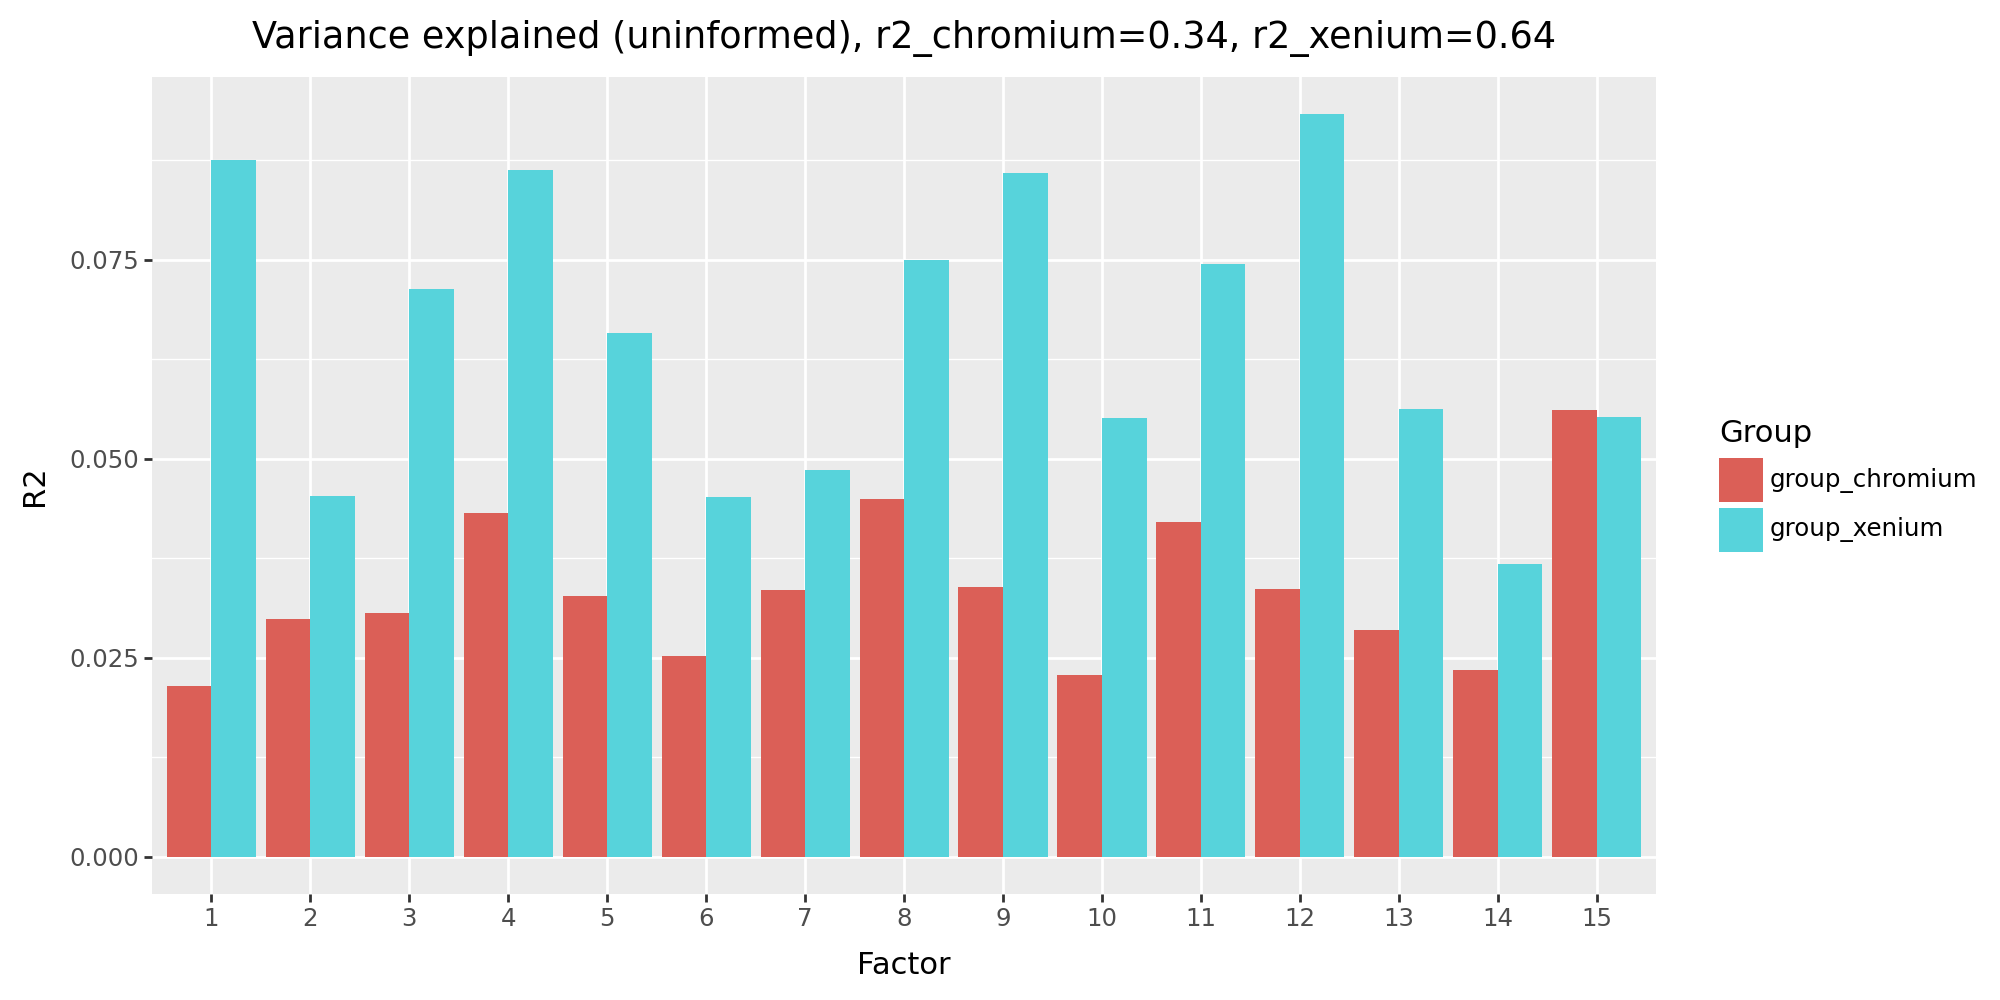

In [7]:
df = pd.concat(cache_uninformed['df_r2_factors'], axis=1).reset_index()
df.columns = ['factor', 'group_xenium', 'group_chromium']
df['factor'] += 1
df_long = df.melt(id_vars="factor", var_name="group", value_name="r2")

r2_chromium = round(cache_uninformed['df_r2_full']['group_chromium'].values[0], 2)
r2_xenium = round(cache_uninformed['df_r2_full']['group_xenium'].values[0], 2)

plot = (
    p9.ggplot(df_long, p9.aes(x="factor", y="r2", fill="group"))
    + p9.geom_bar(stat="identity", position="dodge")
    + p9.labs(x="Factor", y="R2", title=f"Variance explained (uninformed), r2_chromium={r2_chromium}, r2_xenium={r2_xenium}", fill="Group")
    + p9.theme(figure_size=(10, 5))
    + p9.scale_x_discrete(limits=df_long["factor"].unique())
)

plot.show()

In [8]:
df_r2 = pd.concat(cache_uninformed['df_r2_factors'], axis=1).reset_index()
df_r2["mean"] = df_r2[['group_xenium', 'group_chromium']].mean(axis=1)
df_r2 = df_r2.sort_values("mean", ascending=False)

df_r2.head(20)

index group_xenium group_chromium      mean
                  rna            rna          
3      3     0.086362       0.043200  0.064781
11    11     0.093328       0.033657  0.063493
8      8     0.085938       0.033938  0.059938
7      7     0.074964       0.044903  0.059934
10    10     0.074533       0.042116  0.058325
14    14     0.055257       0.056119  0.055688
0      0     0.087503       0.021392  0.054447
2      2     0.071288       0.030628  0.050958
4      4     0.065773       0.032743  0.049258
12    12     0.056296       0.028529  0.042413
6      6     0.048566       0.033468  0.041017
9      9     0.055171       0.022802  0.038986
1      1     0.045289       0.029931  0.037610
5      5     0.045235       0.025263  0.035249
13    13     0.036756       0.023483  0.030119

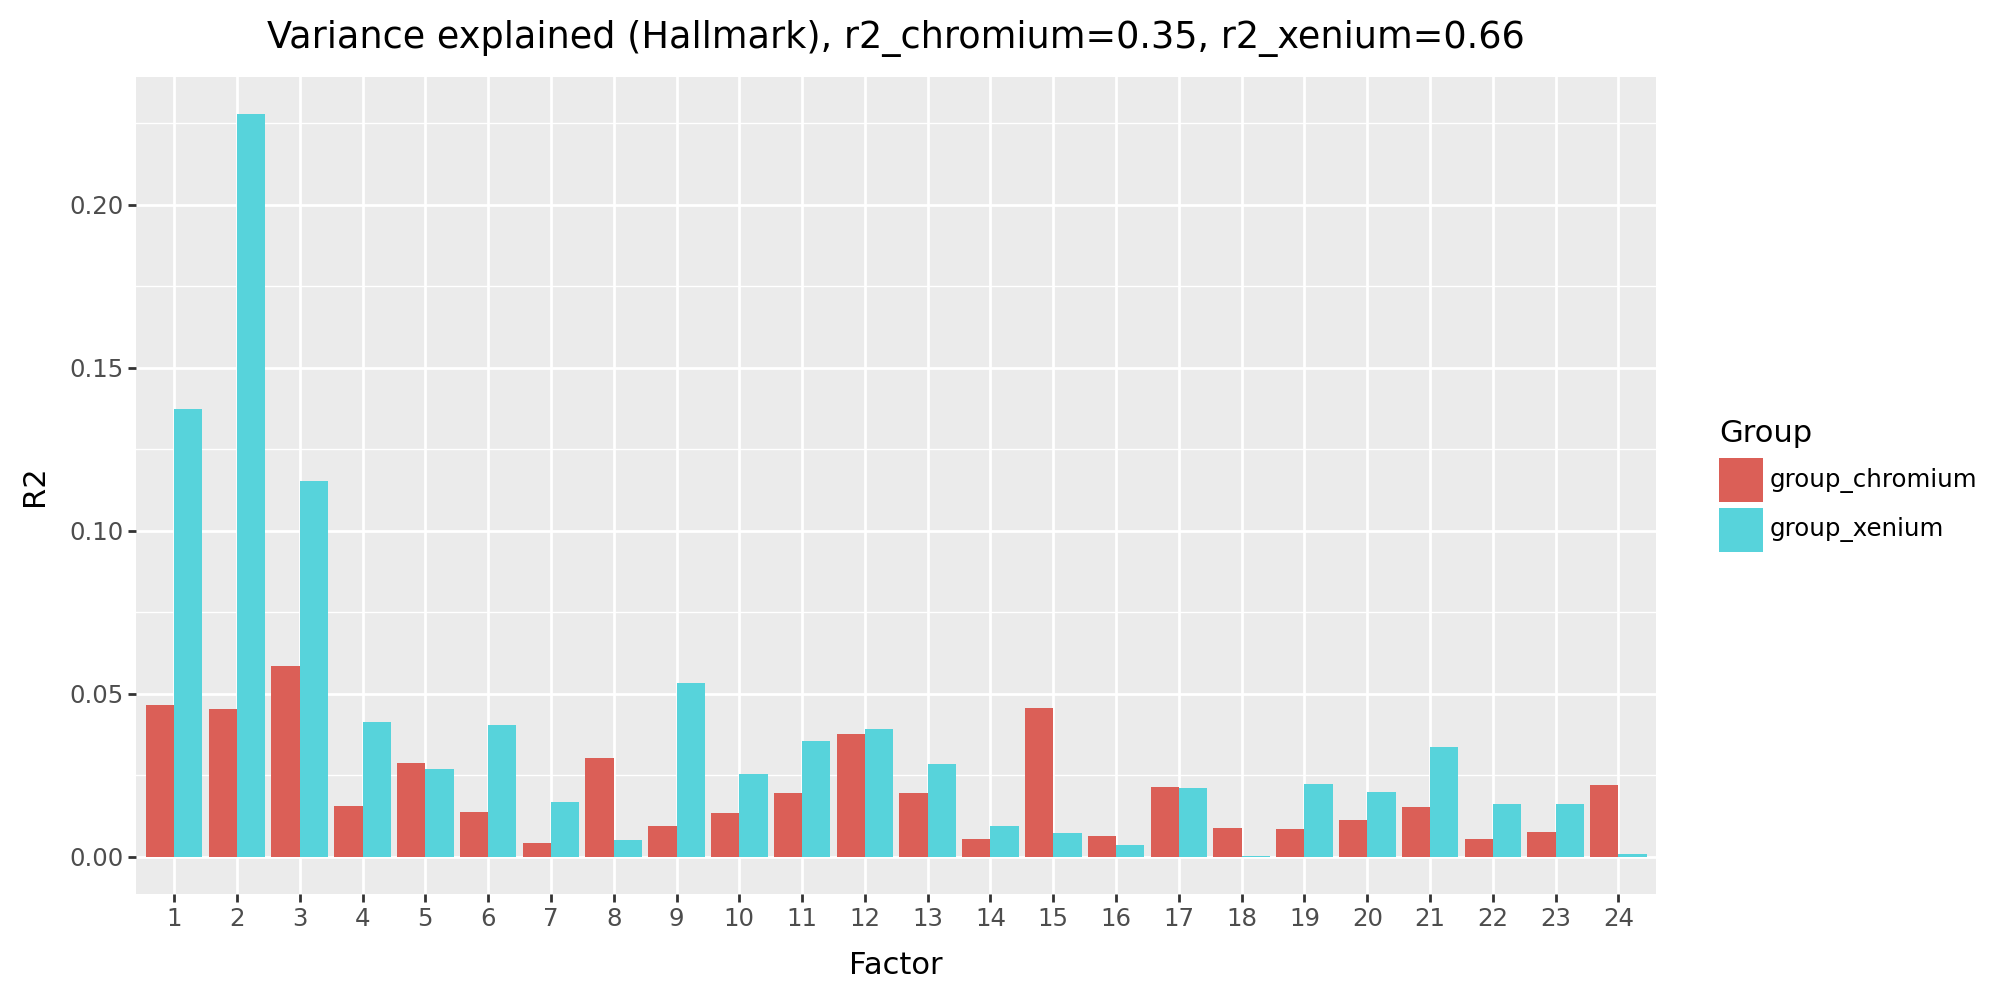

In [9]:
df = pd.concat(cache_hallmark['df_r2_factors'], axis=1).reset_index()
df.columns = ['factor', 'group_xenium', 'group_chromium']
df['factor'] += 1
df_long = df.melt(id_vars="factor", var_name="group", value_name="r2")

r2_chromium = round(cache_hallmark['df_r2_full']['group_chromium'].values[0], 2)
r2_xenium = round(cache_hallmark['df_r2_full']['group_xenium'].values[0], 2)

plot = (
    p9.ggplot(df_long, p9.aes(x="factor", y="r2", fill="group"))
    + p9.geom_bar(stat="identity", position="dodge")
    + p9.labs(x="Factor", y="R2", title=f"Variance explained (Hallmark), r2_chromium={r2_chromium}, r2_xenium={r2_xenium}", fill="Group")
    + p9.theme(figure_size=(10, 5))
    + p9.scale_x_discrete(limits=df_long["factor"].unique())
)

plot.show()

In [11]:
df_r2_hallmark = pd.concat(cache_hallmark['df_r2_factors'], axis=1).reset_index()
df_r2_hallmark.index = cache_hallmark['factor_names']
df_r2_hallmark["mean"] = df_r2_hallmark[['group_xenium', 'group_chromium']].mean(axis=1)
df_r2_hallmark = df_r2_hallmark.sort_values("mean", ascending=False)

df_r2_hallmark.head(20)

index group_xenium group_chromium  \
                                                          rna            rna   
Factor 1                                       1     0.227749       0.045168   
Factor 2                                       0     0.137239       0.046533   
Factor 3                                       2     0.115375       0.058491   
HALLMARK_ESTROGEN_RESPONSE_LATE               11     0.039094       0.037644   
HALLMARK_ANGIOGENESIS                          8     0.053379       0.009280   
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION     3     0.041352       0.015652   
HALLMARK_APOPTOSIS                             4     0.026877       0.028649   
HALLMARK_MYOGENESIS                           10     0.035399       0.019389   
HALLMARK_ALLOGRAFT_REJECTION                   5     0.040368       0.013645   
HALLMARK_APICAL_SURFACE                       14     0.007145       0.045587   
HALLMARK_APICAL_JUNCTION                      20     0.033503       0.015233   
HALLMARK_INFLAMMATORY_RESPONSE                12     0.028482       0.019628   
HALLMARK_INTERFERON_GAMMA_RESPONSE            16     0.021176       0.021239   
HALLMARK_IL2_STAT5_SIGNALING                   9     0.025283       0.013461   
HALLMARK_COMPLEMENT                            7     0.005164       0.030376   
HALLMARK_P53_PATHWAY                          19     0.019883       0.011352   
HALLMARK_UV_RESPONSE_DN                       18     0.022303       0.008349   
HALLMARK_IL6_JAK_STAT3_SIGNALING              22     0.016230       0.007521   
HALLMARK_INTERFERON_ALPHA_RESPONSE            23     0.000943       0.022047   
HALLMARK_HYPOXIA                              21     0.016199       0.005540   

                                                mean  
                                                      
Factor 1                                    0.136459  
Factor 2                                    0.091886  
Factor 3                                    0.086933  
HALLMARK_ESTROGEN_RESPONSE_LATE             0.038369  
HALLMARK_ANGIOGENESIS                       0.031330  
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  0.028502  
HALLMARK_APOPTOSIS                          0.027763  
HALLMARK_MYOGENESIS                         0.027394  
HALLMARK_ALLOGRAFT_REJECTION                0.027006  
HALLMARK_APICAL_SURFACE                     0.026366  
HALLMARK_APICAL_JUNCTION                    0.024368  
HALLMARK_INFLAMMATORY_RESPONSE              0.024055  
HALLMARK_INTERFERON_GAMMA_RESPONSE          0.021208  
HALLMARK_IL2_STAT5_SIGNALING                0.019372  
HALLMARK_COMPLEMENT                         0.017770  
HALLMARK_P53_PATHWAY                        0.015617  
HALLMARK_UV_RESPONSE_DN                     0.015326  
HALLMARK_IL6_JAK_STAT3_SIGNALING            0.011876  
HALLMARK_INTERFERON_ALPHA_RESPONSE          0.011495  
HALLMARK_HYPOXIA                            0.010869

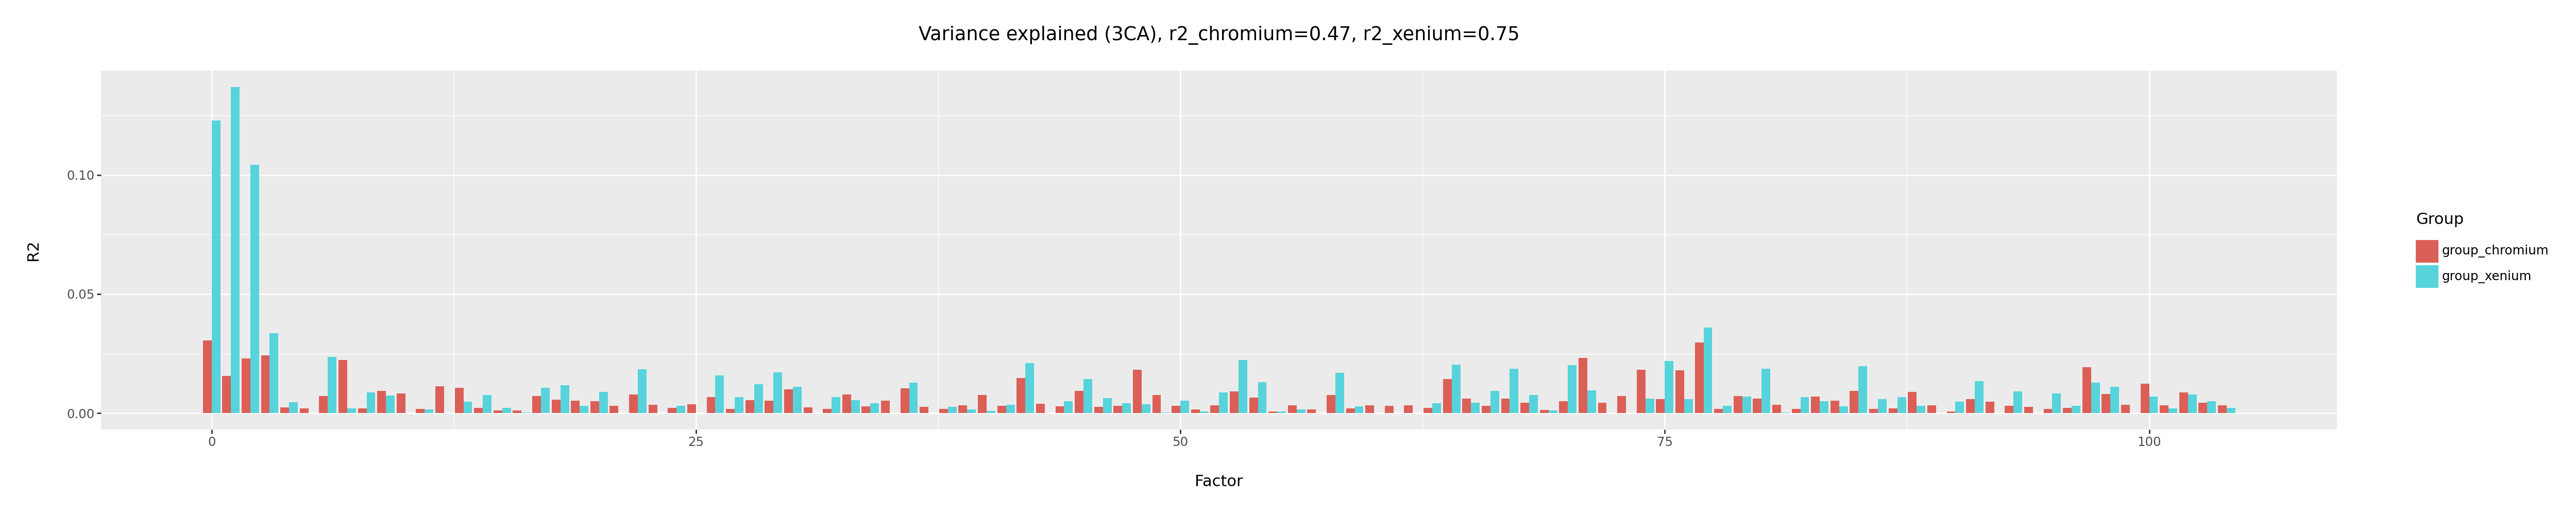

In [12]:
df = pd.concat(cache_3CA['df_r2_factors'], axis=1).reset_index()
df.columns = ['factor', 'group_xenium', 'group_chromium']
df_long = df.melt(id_vars="factor", var_name="group", value_name="r2")

r2_chromium = round(cache_3CA['df_r2_full']['group_chromium'].values[0], 2)
r2_xenium = round(cache_3CA['df_r2_full']['group_xenium'].values[0], 2)

plot = (
    p9.ggplot(df_long, p9.aes(x="factor", y="r2", fill="group"))
    + p9.geom_bar(stat="identity", position="dodge")
    + p9.labs(x="Factor", y="R2", title=f"Variance explained (3CA), r2_chromium={r2_chromium}, r2_xenium={r2_xenium}", fill="Group")
    + p9.theme(figure_size=(25, 5))
)

plot.show()

In [14]:
df_r2_3ca = pd.concat(cache_3CA['df_r2_factors'], axis=1).reset_index()
df_r2_3ca.index = cache_3CA['factor_names']
df_r2_3ca["mean"] = df_r2_3ca[['group_xenium', 'group_chromium']].mean(axis=1)
df_r2_3ca = df_r2_3ca.sort_values("mean", ascending=False)

df_r2_3ca.head(20)

index group_xenium  \
                                                                 rna   
Factor 1                                              0     0.122868   
Factor 2                                              1     0.136969   
Factor 3                                              2     0.104205   
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_MYOFIBROBLASTS    77     0.035870   
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_1              3     0.033508   
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_8             42     0.020919   
GAVISH_3CA_METAPROGRAM_CD8_T_CELLS_INTERFERON        64     0.020323   
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_MHC_II            71     0.009460   
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_PI16_POS          97     0.012749   
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_INTERFERON        53     0.022276   
GAVISH_3CA_METAPROGRAM_EPITHELIAL_ALVEOLAR            6     0.023557   
GAVISH_3CA_METAPROGRAM_B_CELLS_GERMINAL_CENTER       85     0.019751   
GAVISH_3CA_METAPROGRAM_MACROPHAGES_MES_GLYCOLYSIS    75     0.021918   
GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_NAIVE_1           22     0.018421   
GAVISH_3CA_METAPROGRAM_ENDOTHELIAL_STRESS            70     0.020207   
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_10            80     0.018624   
GAVISH_3CA_METAPROGRAM_ENDOTHELIAL_COAGULATION       58     0.016971   
GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2            67     0.018534   
GAVISH_3CA_METAPROGRAM_EPITHELIAL_EPI_2               7     0.001968   
GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_INTERFERON        74     0.005995   

                                                  group_chromium      mean  
                                                             rna            
Factor 1                                                0.030457  0.076662  
Factor 2                                                0.015698  0.076334  
Factor 3                                                0.023006  0.063605  
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_MYOFIBROBLASTS       0.029632  0.032751  
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_1                0.024226  0.028867  
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_8                0.014740  0.017830  
GAVISH_3CA_METAPROGRAM_CD8_T_CELLS_INTERFERON           0.014403  0.017363  
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_MHC_II               0.023207  0.016334  
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_PI16_POS             0.019208  0.015979  
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_INTERFERON           0.009008  0.015642  
GAVISH_3CA_METAPROGRAM_EPITHELIAL_ALVEOLAR              0.007127  0.015342  
GAVISH_3CA_METAPROGRAM_B_CELLS_GERMINAL_CENTER          0.009331  0.014541  
GAVISH_3CA_METAPROGRAM_MACROPHAGES_MES_GLYCOLYSIS       0.005820  0.013869  
GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_NAIVE_1              0.007834  0.013127  
GAVISH_3CA_METAPROGRAM_ENDOTHELIAL_STRESS               0.005003  0.012605  
GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_10               0.006063  0.012343  
GAVISH_3CA_METAPROGRAM_ENDOTHELIAL_COAGULATION          0.007618  0.012294  
GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2               0.006054  0.012294  
GAVISH_3CA_METAPROGRAM_EPITHELIAL_EPI_2                 0.022247  0.012107  
GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_INTERFERON           0.018192  0.012094

## Correlation of uninformed and 3CA informed factors

In [15]:
z_3CA = np.concat([cache_3CA["factors"].mean['group_chromium'], cache_3CA["factors"].mean["group_xenium"]], axis=1)
z_uninformed = np.concat([cache_uninformed["factors"].mean['group_chromium'], cache_uninformed["factors"].mean["group_xenium"]], axis=1)

w_3CA = cache_3CA["weights"].mean['rna']
w_uninformed = cache_uninformed["weights"].mean['rna']

informed_ind, uninformed_ind, _ = match(z_3CA, z_uninformed, dim=0)

z_3CA_matched = z_3CA[informed_ind]
z_uninformed_matched = z_uninformed[uninformed_ind]

w_3CA_matched = w_3CA[informed_ind]
w_uninformed_matched = w_uninformed[uninformed_ind]

matched_factor_names = cache_3CA["factor_names"][informed_ind]

z_3CA_matched = pd.DataFrame(z_3CA_matched.T, columns=matched_factor_names)
z_uninformed_matched = pd.DataFrame(z_uninformed_matched.T, columns=[f"Factor {i}" for i in uninformed_ind])

w_3CA_matched = pd.DataFrame(w_3CA_matched.T, columns=matched_factor_names)
w_uninformed_matched = pd.DataFrame(w_uninformed_matched.T, columns=[f"Factor {i}" for i in uninformed_ind])

z_corr = np.zeros([z_uninformed_matched.shape[1], z_3CA_matched.shape[1]])
for i, factor_1 in enumerate(z_uninformed_matched.columns):
    for j, factor_2 in enumerate(z_3CA_matched.columns):
        z_corr[i, j] = np.corrcoef(z_uninformed_matched[factor_1], z_3CA_matched[factor_2])[0, 1]

z_corr = pd.DataFrame(z_corr, columns=z_3CA_matched.columns, index=z_uninformed_matched.columns)

w_corr = np.zeros([w_uninformed_matched.shape[1], w_3CA_matched.shape[1]])
for i, factor_1 in enumerate(w_uninformed_matched.columns):
    for j, factor_2 in enumerate(w_3CA_matched.columns):
        w_corr[i, j] = np.corrcoef(w_uninformed_matched[factor_1], w_3CA_matched[factor_2])[0, 1]

w_corr = pd.DataFrame(w_corr.T, columns=w_3CA_matched.columns, index=w_uninformed_matched.columns)

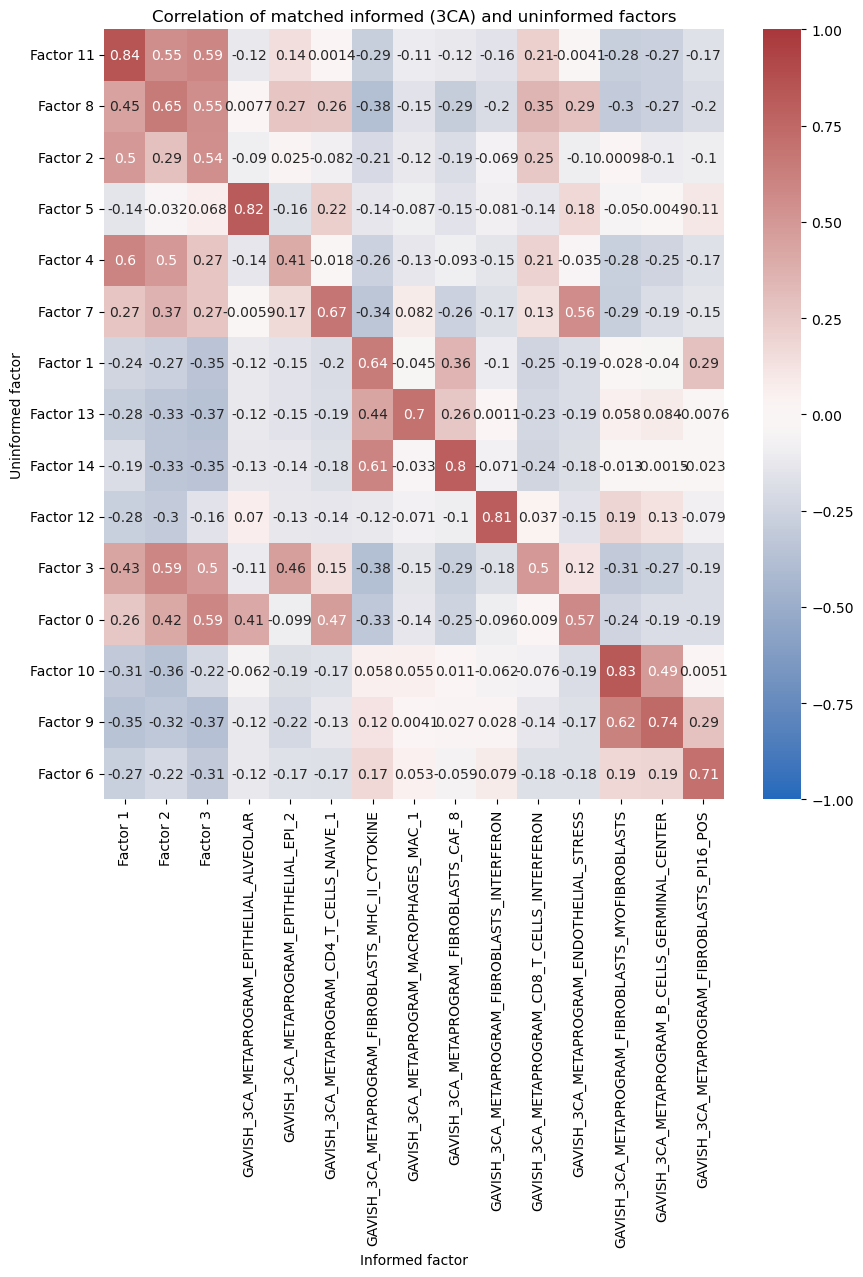

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
heatmap = sns.heatmap(z_corr, annot=True, cmap="vlag", vmax=1, vmin=-1, ax=ax)
ax.set_xlabel("Informed factor")
ax.set_ylabel("Uninformed factor")
ax.set_title("Correlation of matched informed (3CA) and uninformed factors")
plt.show()

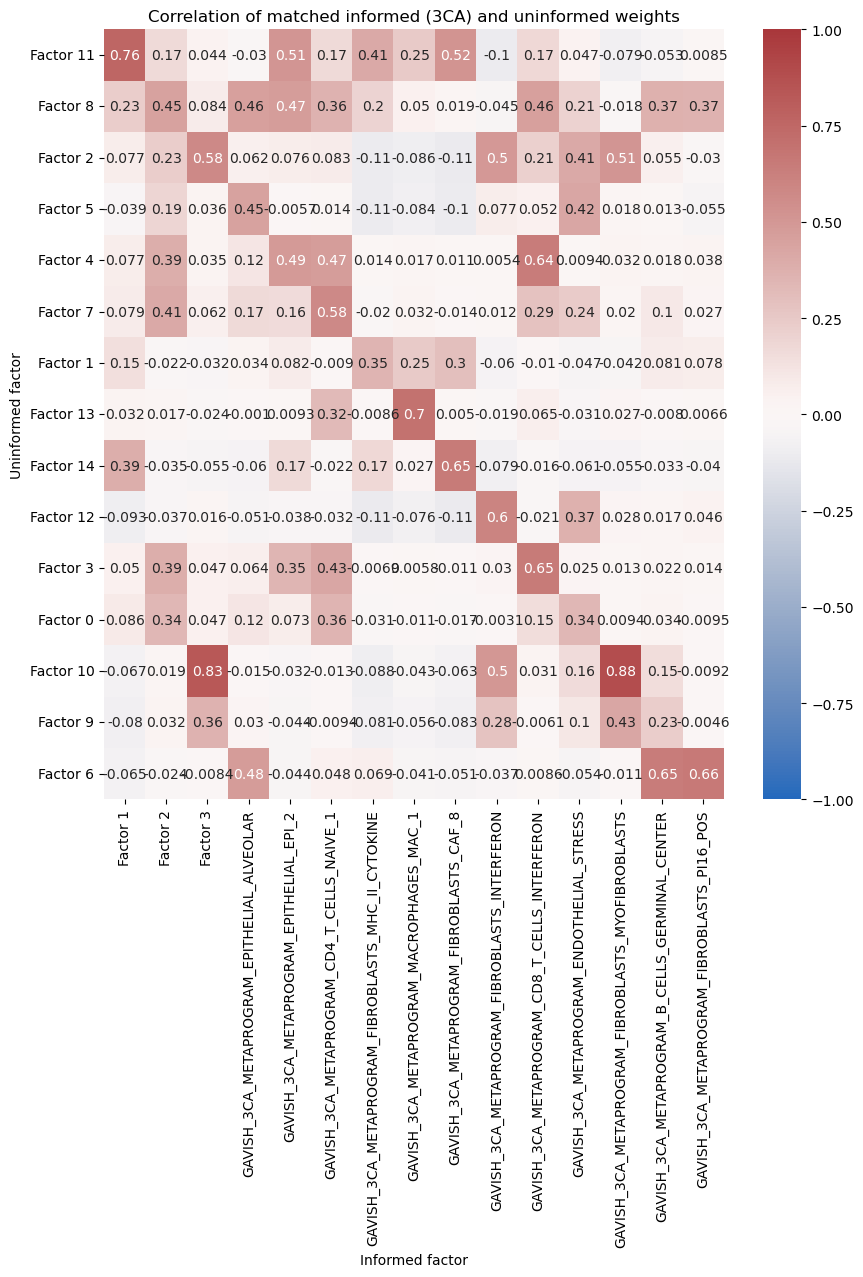

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
heatmap = sns.heatmap(w_corr, annot=True, cmap="vlag", vmax=1, vmin=-1, ax=ax)
ax.set_xlabel("Informed factor")
ax.set_ylabel("Uninformed factor")
ax.set_title("Correlation of matched informed (3CA) and uninformed weights")
plt.show()

## Correlation of uninformed and Hallmark informed factors

In [27]:
z_hallmark = np.concat([cache_hallmark["factors"].mean['group_chromium'], cache_hallmark["factors"].mean["group_xenium"]], axis=1)
z_uninformed = np.concat([cache_uninformed["factors"].mean['group_chromium'], cache_uninformed["factors"].mean["group_xenium"]], axis=1)

w_hallmark = cache_hallmark["weights"].mean['rna']
w_uninformed = cache_uninformed["weights"].mean['rna']

informed_ind, uninformed_ind, _ = match(z_hallmark, z_uninformed, dim=0)

z_hallmark_matched = z_hallmark[informed_ind]
z_uninformed_matched = z_uninformed[uninformed_ind]

w_hallmark_matched = w_hallmark[informed_ind]
w_uninformed_matched = w_uninformed[uninformed_ind]

matched_factor_names = cache_hallmark["factor_names"][informed_ind]

z_hallmark_matched = pd.DataFrame(z_hallmark_matched.T, columns=matched_factor_names)
z_uninformed_matched = pd.DataFrame(z_uninformed_matched.T, columns=[f"Factor {i}" for i in uninformed_ind])

w_hallmark_matched = pd.DataFrame(w_hallmark_matched.T, columns=matched_factor_names)
w_uninformed_matched = pd.DataFrame(w_uninformed_matched.T, columns=[f"Factor {i}" for i in uninformed_ind])

z_corr = np.zeros([z_uninformed_matched.shape[1], z_hallmark_matched.shape[1]])
for i, factor_1 in enumerate(z_uninformed_matched.columns):
    for j, factor_2 in enumerate(z_hallmark_matched.columns):
        z_corr[i, j] = np.corrcoef(z_uninformed_matched[factor_1], z_hallmark_matched[factor_2])[0, 1]

z_corr = pd.DataFrame(z_corr, columns=z_hallmark_matched.columns, index=z_uninformed_matched.columns)

w_corr = np.zeros([w_uninformed_matched.shape[1], w_hallmark_matched.shape[1]])
for i, factor_1 in enumerate(w_uninformed_matched.columns):
    for j, factor_2 in enumerate(w_hallmark_matched.columns):
        w_corr[i, j] = np.corrcoef(w_uninformed_matched[factor_1], w_hallmark_matched[factor_2])[0, 1]

w_corr = pd.DataFrame(w_corr.T, columns=w_hallmark_matched.columns, index=w_uninformed_matched.columns)

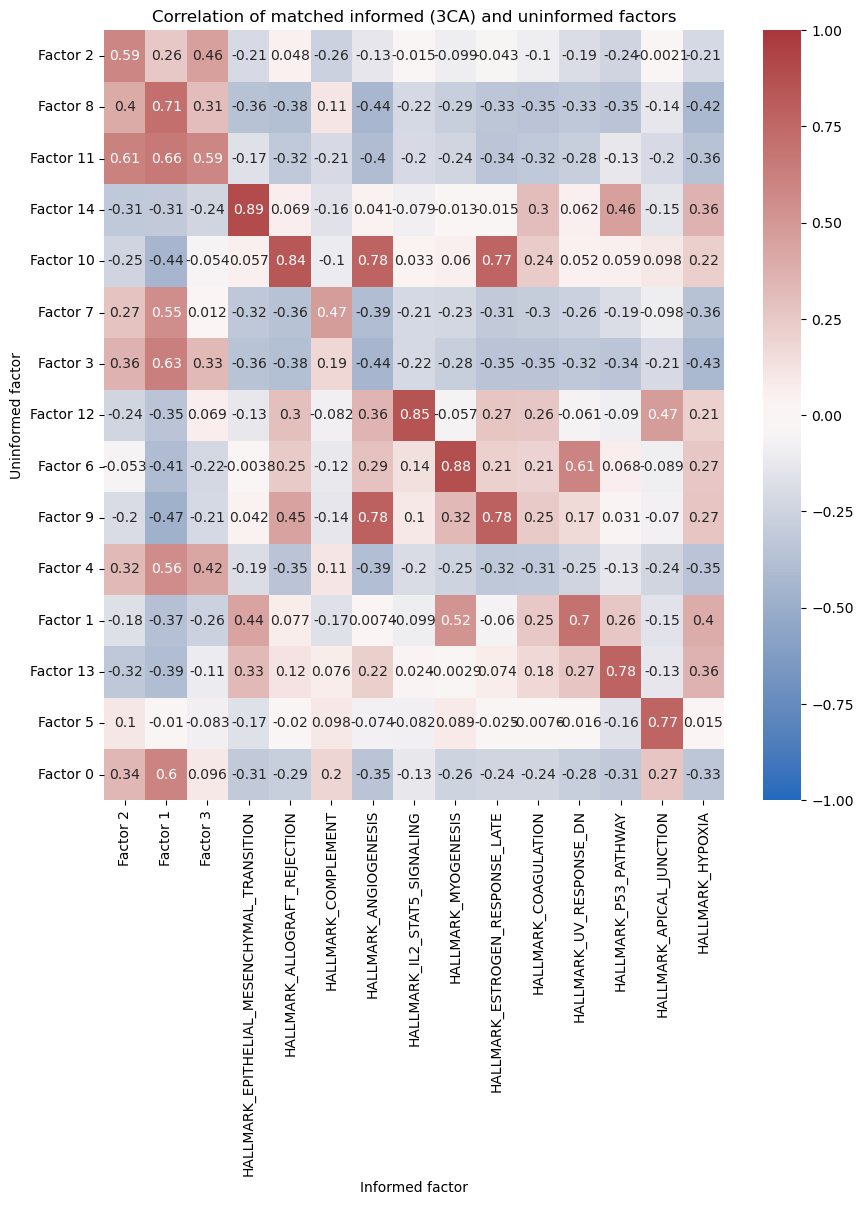

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
heatmap = sns.heatmap(z_corr, annot=True, cmap="vlag", vmax=1, vmin=-1, ax=ax)
ax.set_xlabel("Informed factor")
ax.set_ylabel("Uninformed factor")
ax.set_title("Correlation of matched informed (3CA) and uninformed factors")
plt.show()

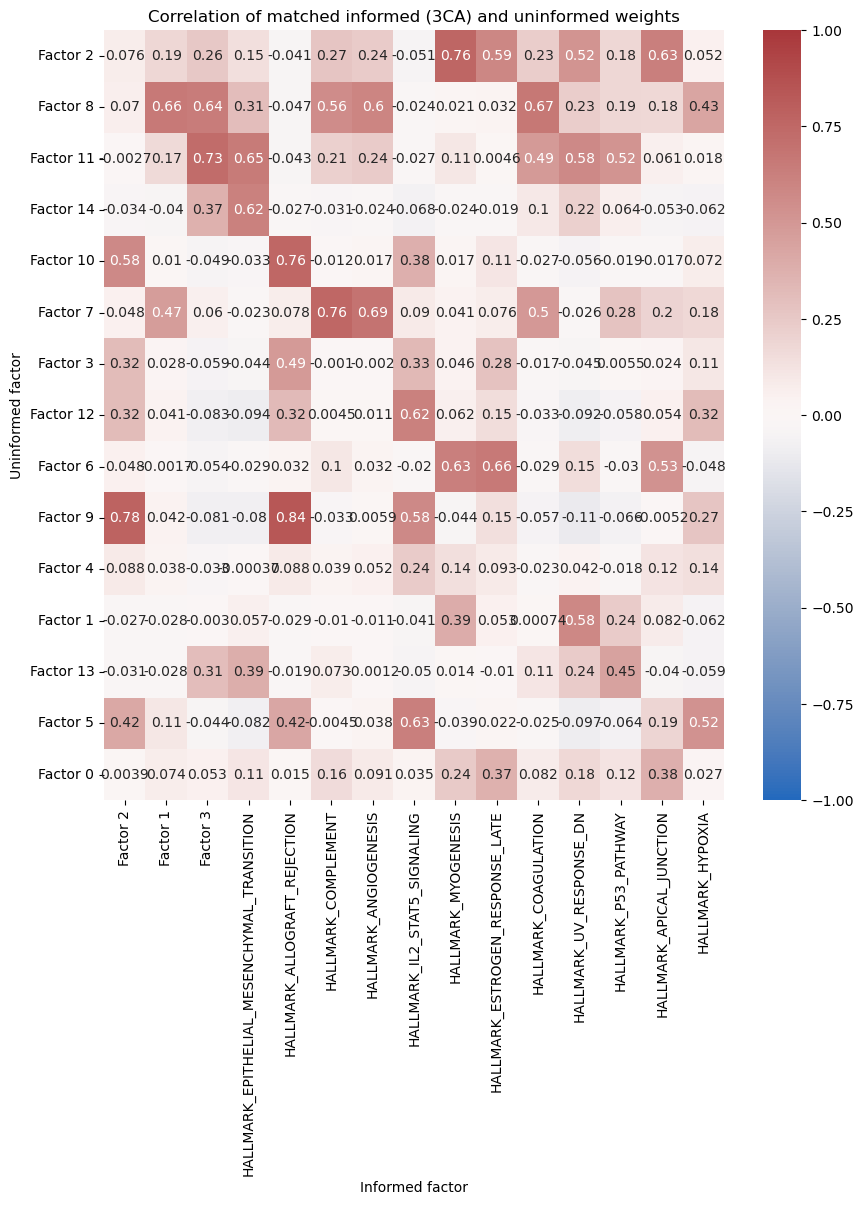

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
heatmap = sns.heatmap(w_corr, annot=True, cmap="vlag", vmax=1, vmin=-1, ax=ax)
ax.set_xlabel("Informed factor")
ax.set_ylabel("Uninformed factor")
ax.set_title("Correlation of matched informed (3CA) and uninformed weights")
plt.show()

## Cell type activity of 3CA factors

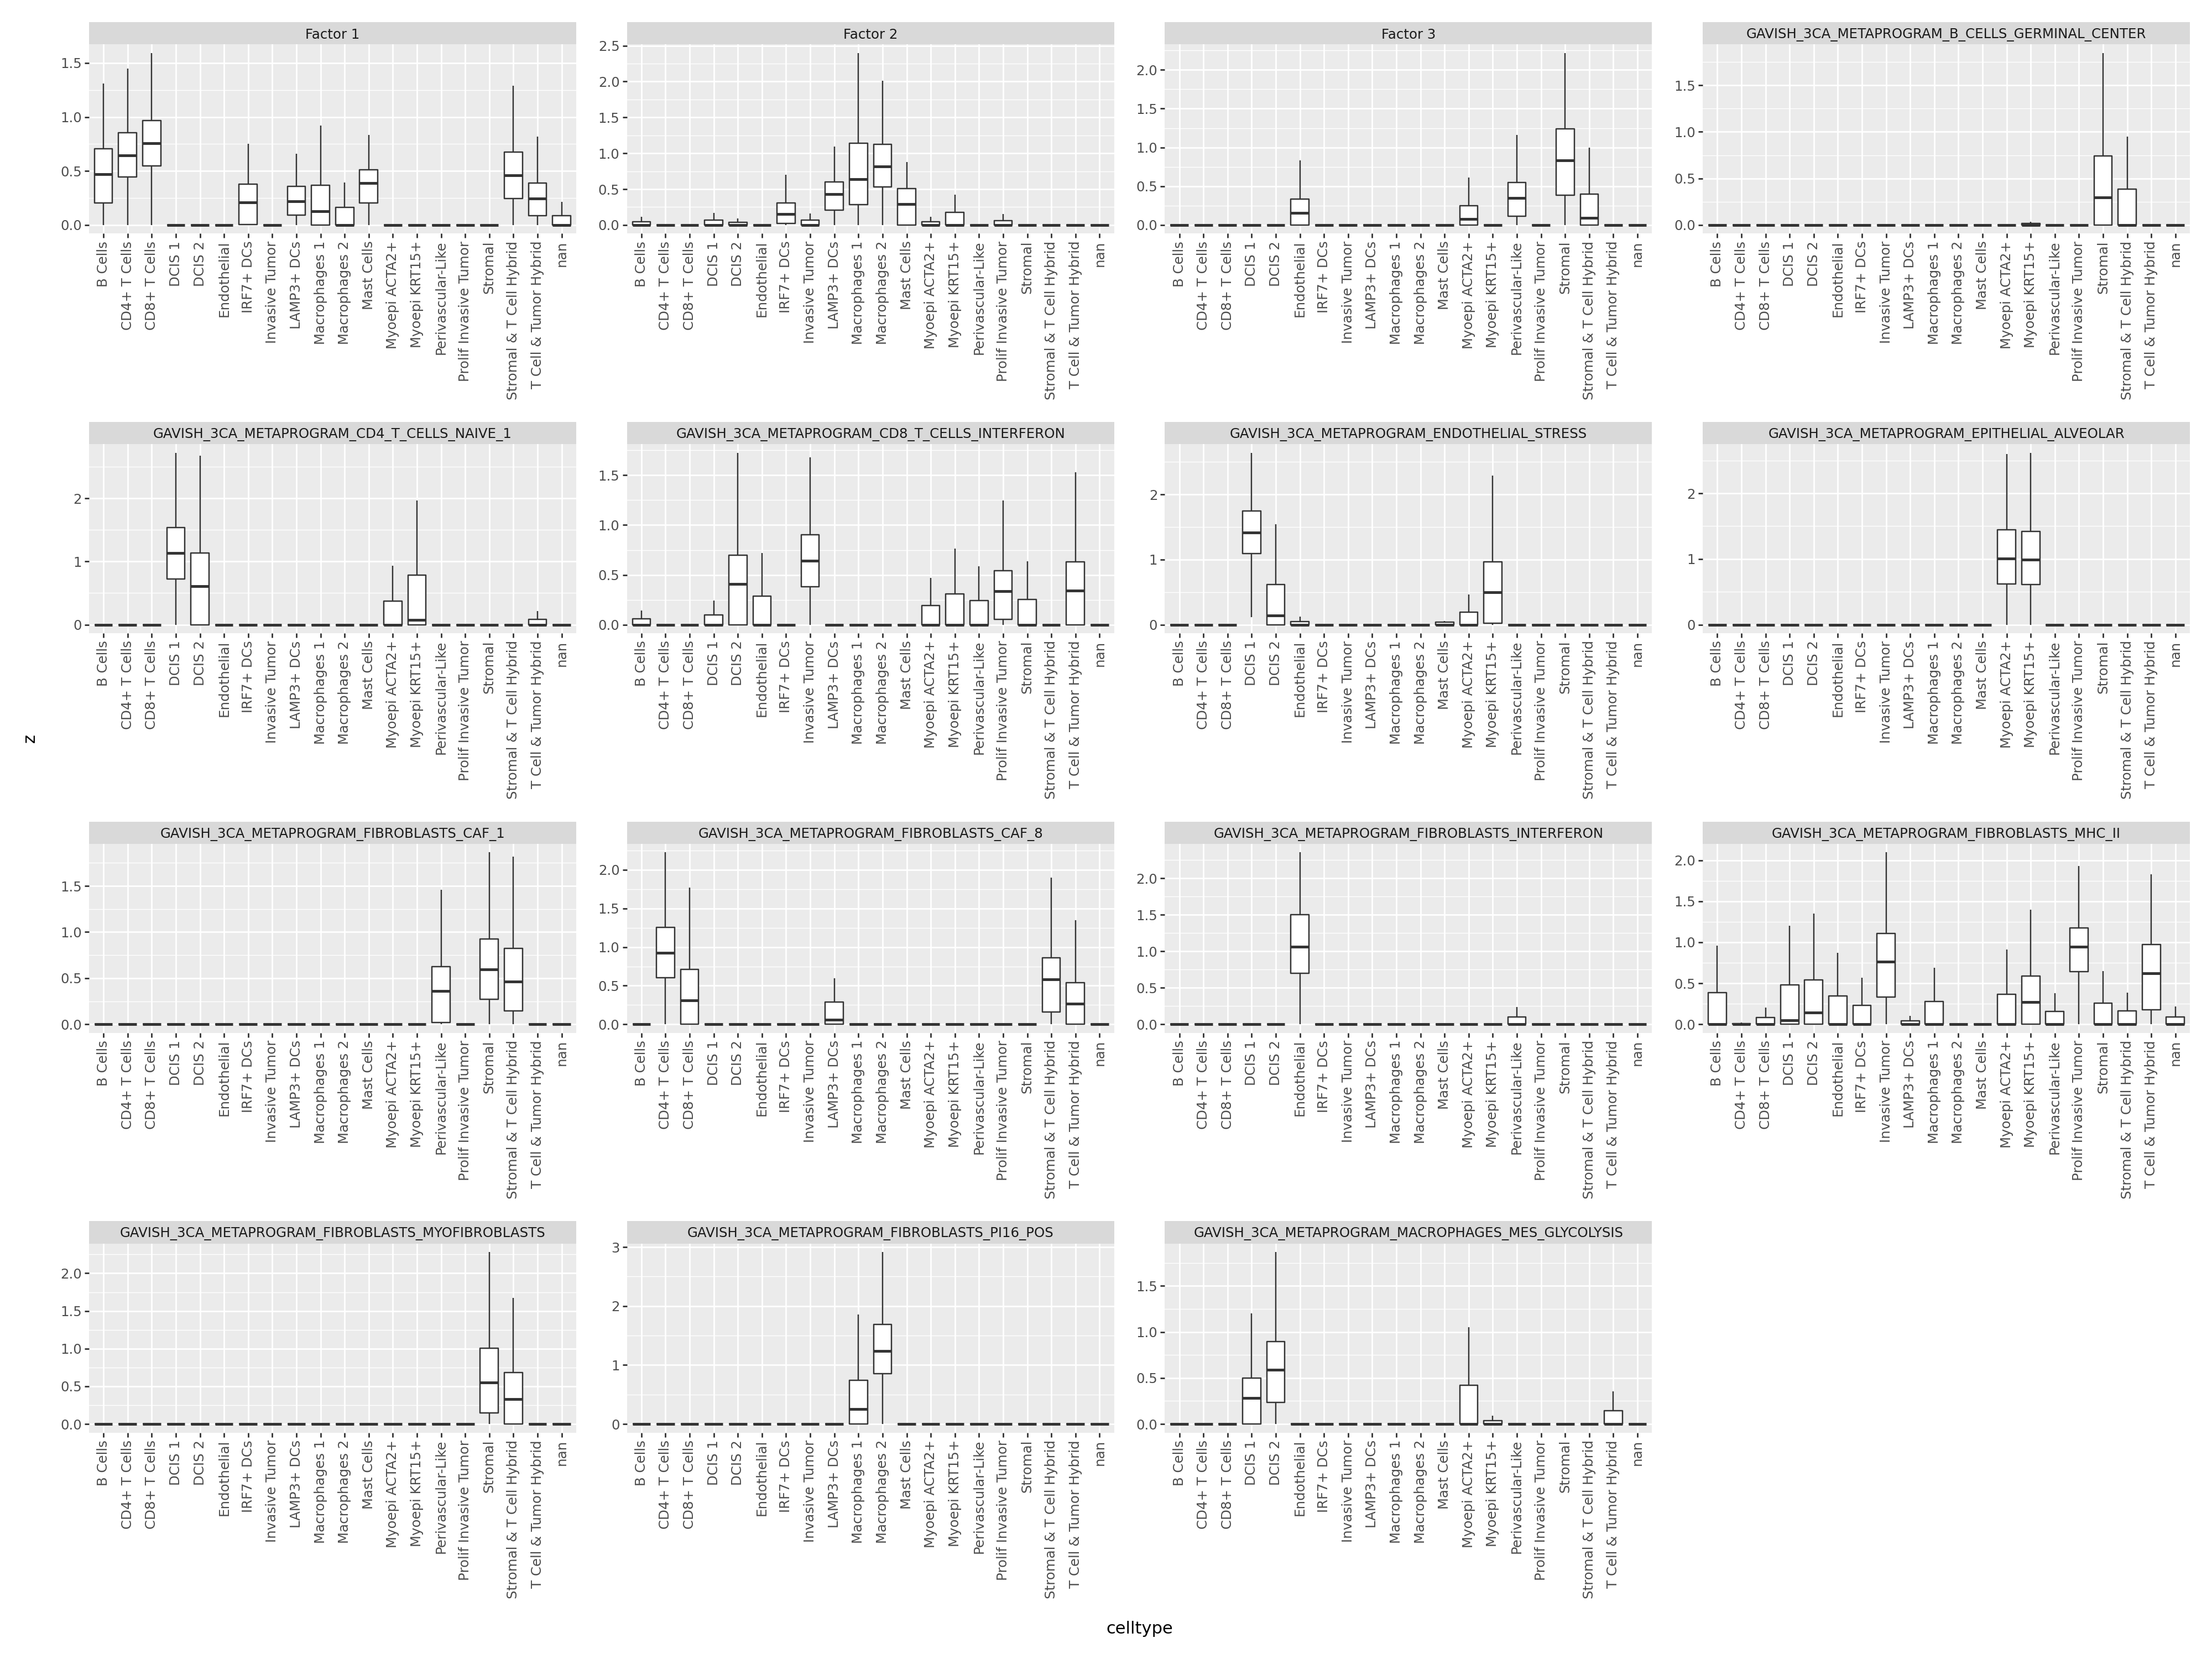

In [21]:
# DataFrame with all factors and factor naes
z_3CA_chromium_df = pd.DataFrame(cache_3CA["factors"].mean["group_chromium"].T, columns=cache_3CA["factor_names"])

# Select top 15 factors wrt r2
z_3CA_chromium_df = z_3CA_chromium_df[df_r2_3ca.index[:15]]

# add cell type information
z_3CA_chromium_df["celltype"] = data["group_chromium"]["rna"].obs["celltype"].values

# melt dataframe for plotting
z_3CA_chromium_df_long = z_3CA_chromium_df.melt(id_vars="celltype", var_name="factor", value_name="z")

plot = (
    p9.ggplot(z_3CA_chromium_df_long, p9.aes(x="celltype", y="z"))
    + p9.geom_boxplot(outlier_shape="")
    + p9.facet_wrap("~factor", scales="free")
    + p9.theme(figure_size=(20, 15), axis_text_x=p9.element_text(rotation=90))
)
plot.show()

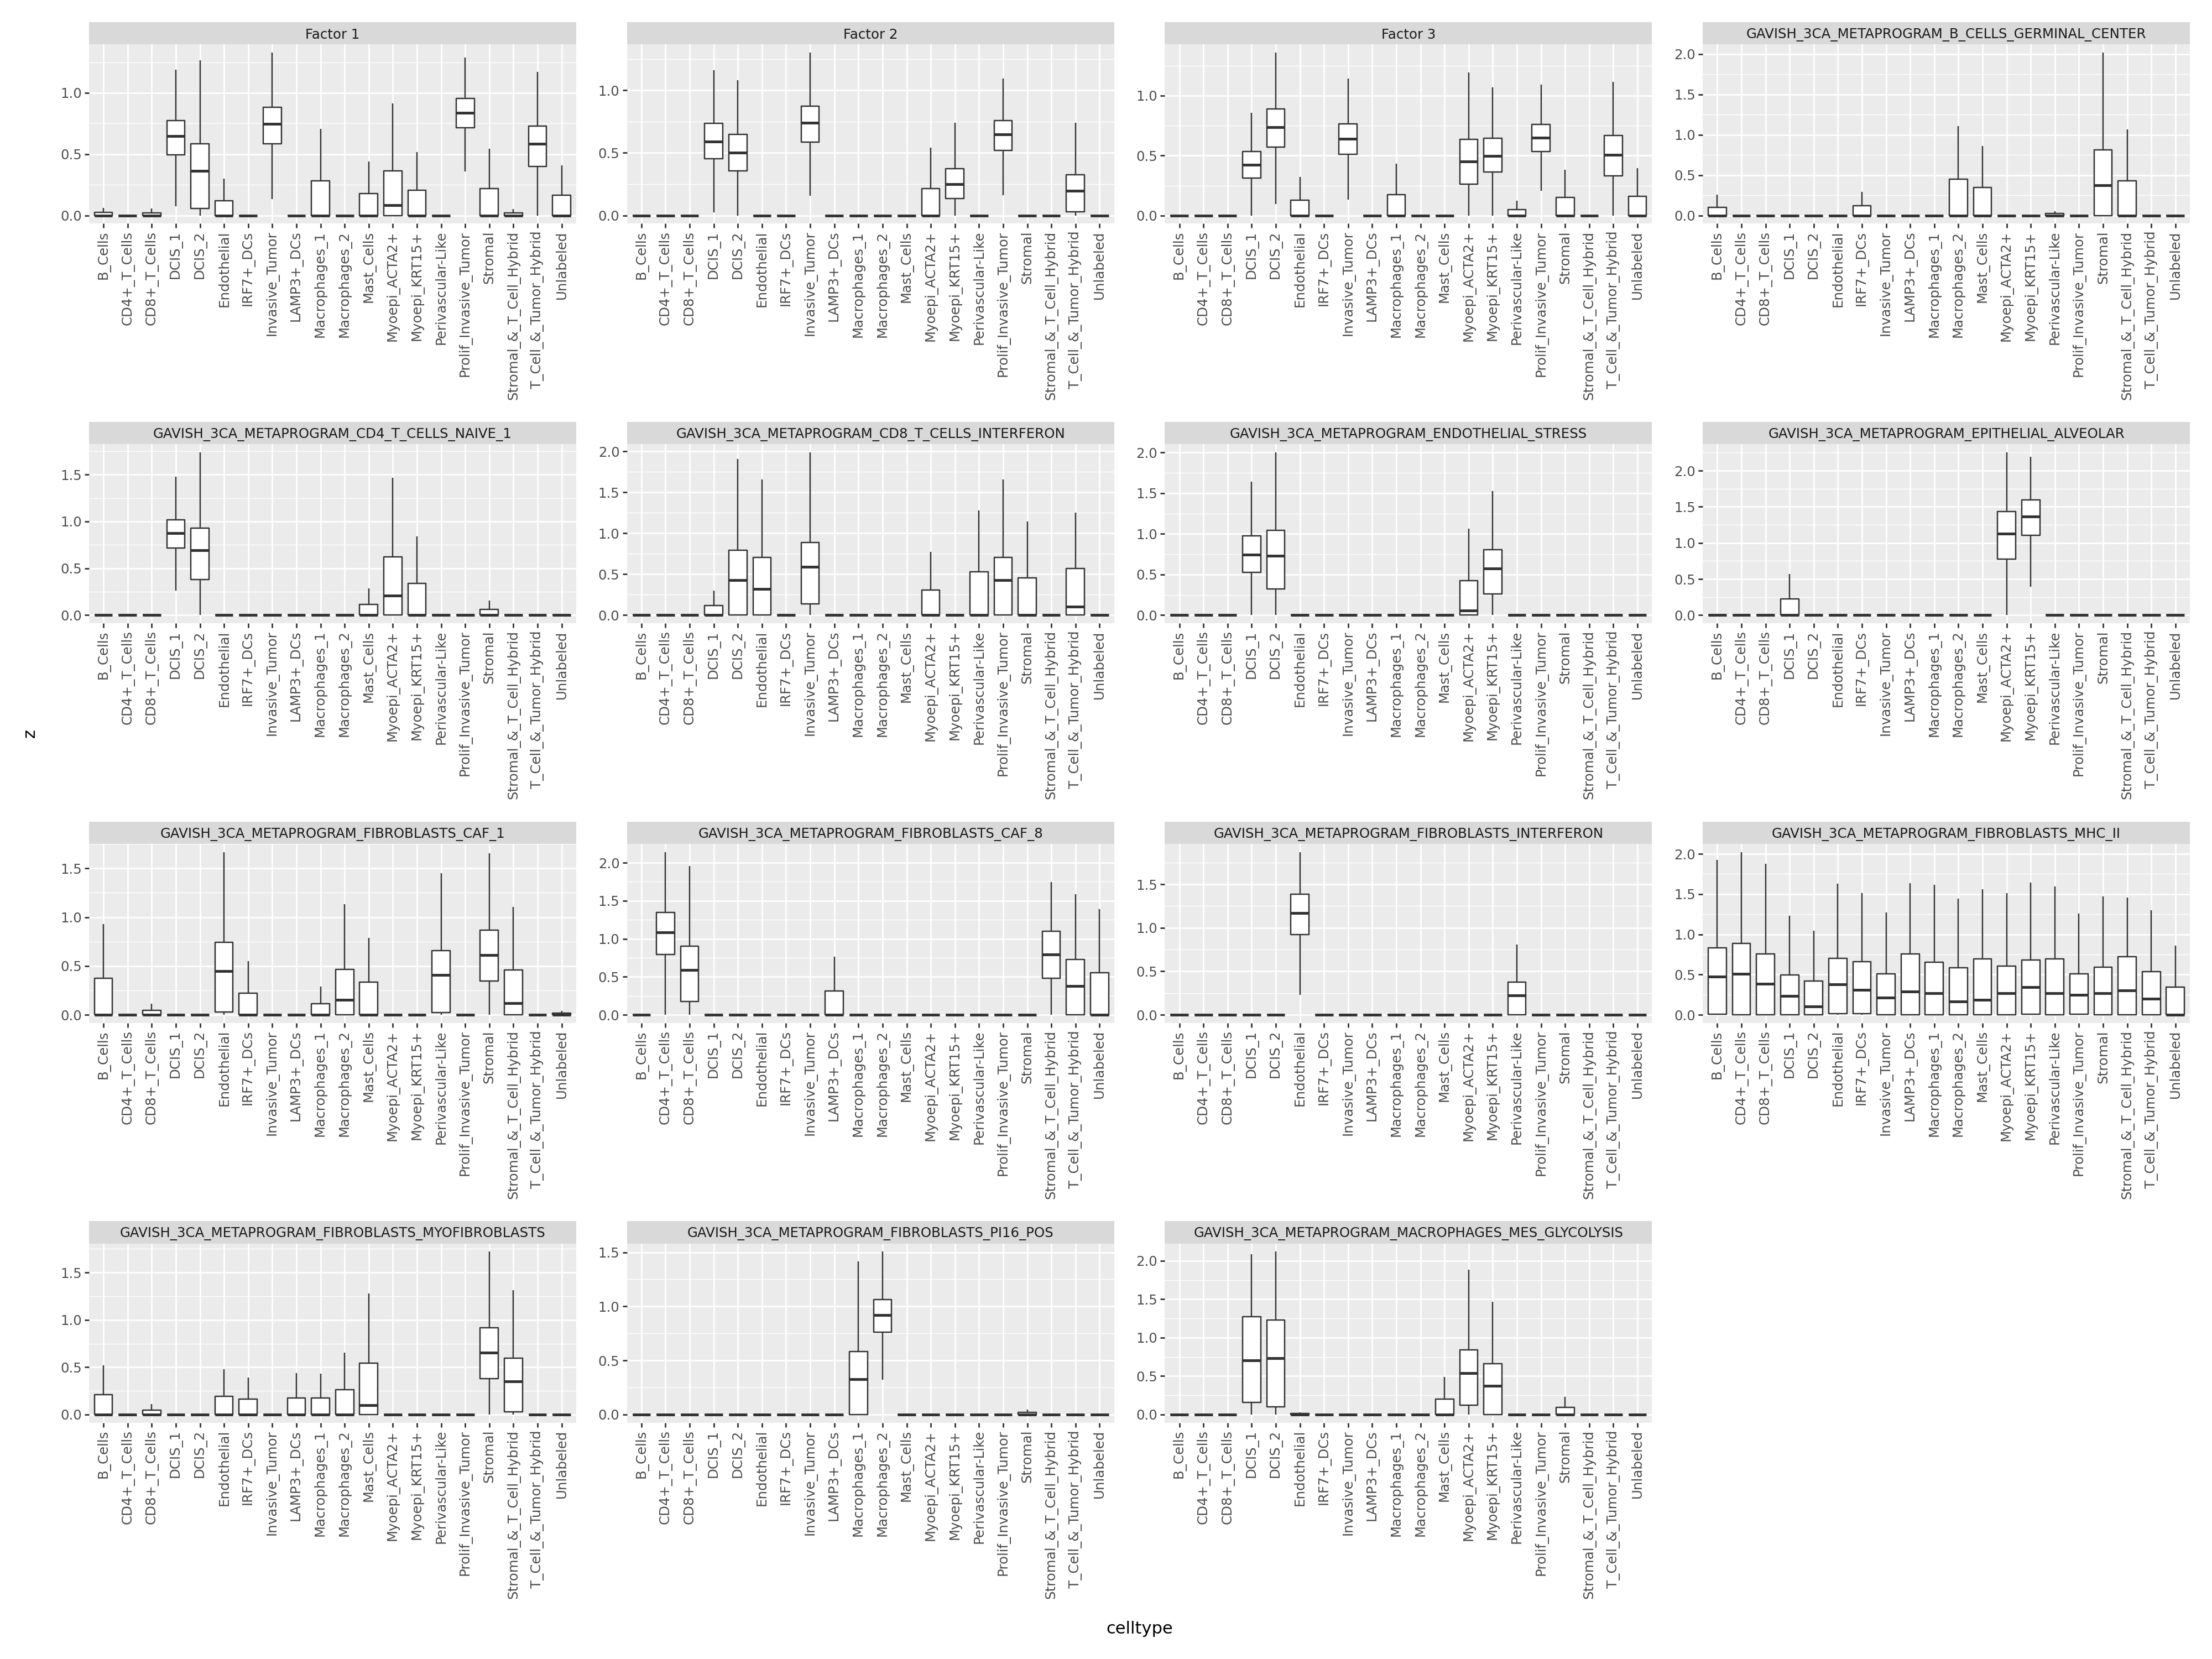

In [23]:
# DataFrame with all factors and factor naes
z_3CA_xenium_df = pd.DataFrame(cache_3CA["factors"].mean["group_xenium"].T, columns=cache_3CA["factor_names"])

# Select top 15 factors wrt r2
z_3CA_xenium_df = z_3CA_xenium_df[df_r2_3ca.index[:15]]

# add cell type information
z_3CA_xenium_df["celltype"] = data["group_xenium"]["rna"].obs["celltype"].values

# melt dataframe for plotting
z_3CA_xenium_df_long = z_3CA_xenium_df.melt(id_vars="celltype", var_name="factor", value_name="z")

plot = (
    p9.ggplot(z_3CA_xenium_df_long, p9.aes(x="celltype", y="z"))
    + p9.geom_boxplot(outlier_shape="")
    + p9.facet_wrap("~factor", scales="free")
    + p9.theme(figure_size=(20, 15), axis_text_x=p9.element_text(rotation=90))
)
plot.show()

## Cell type activity of Hallmark factors

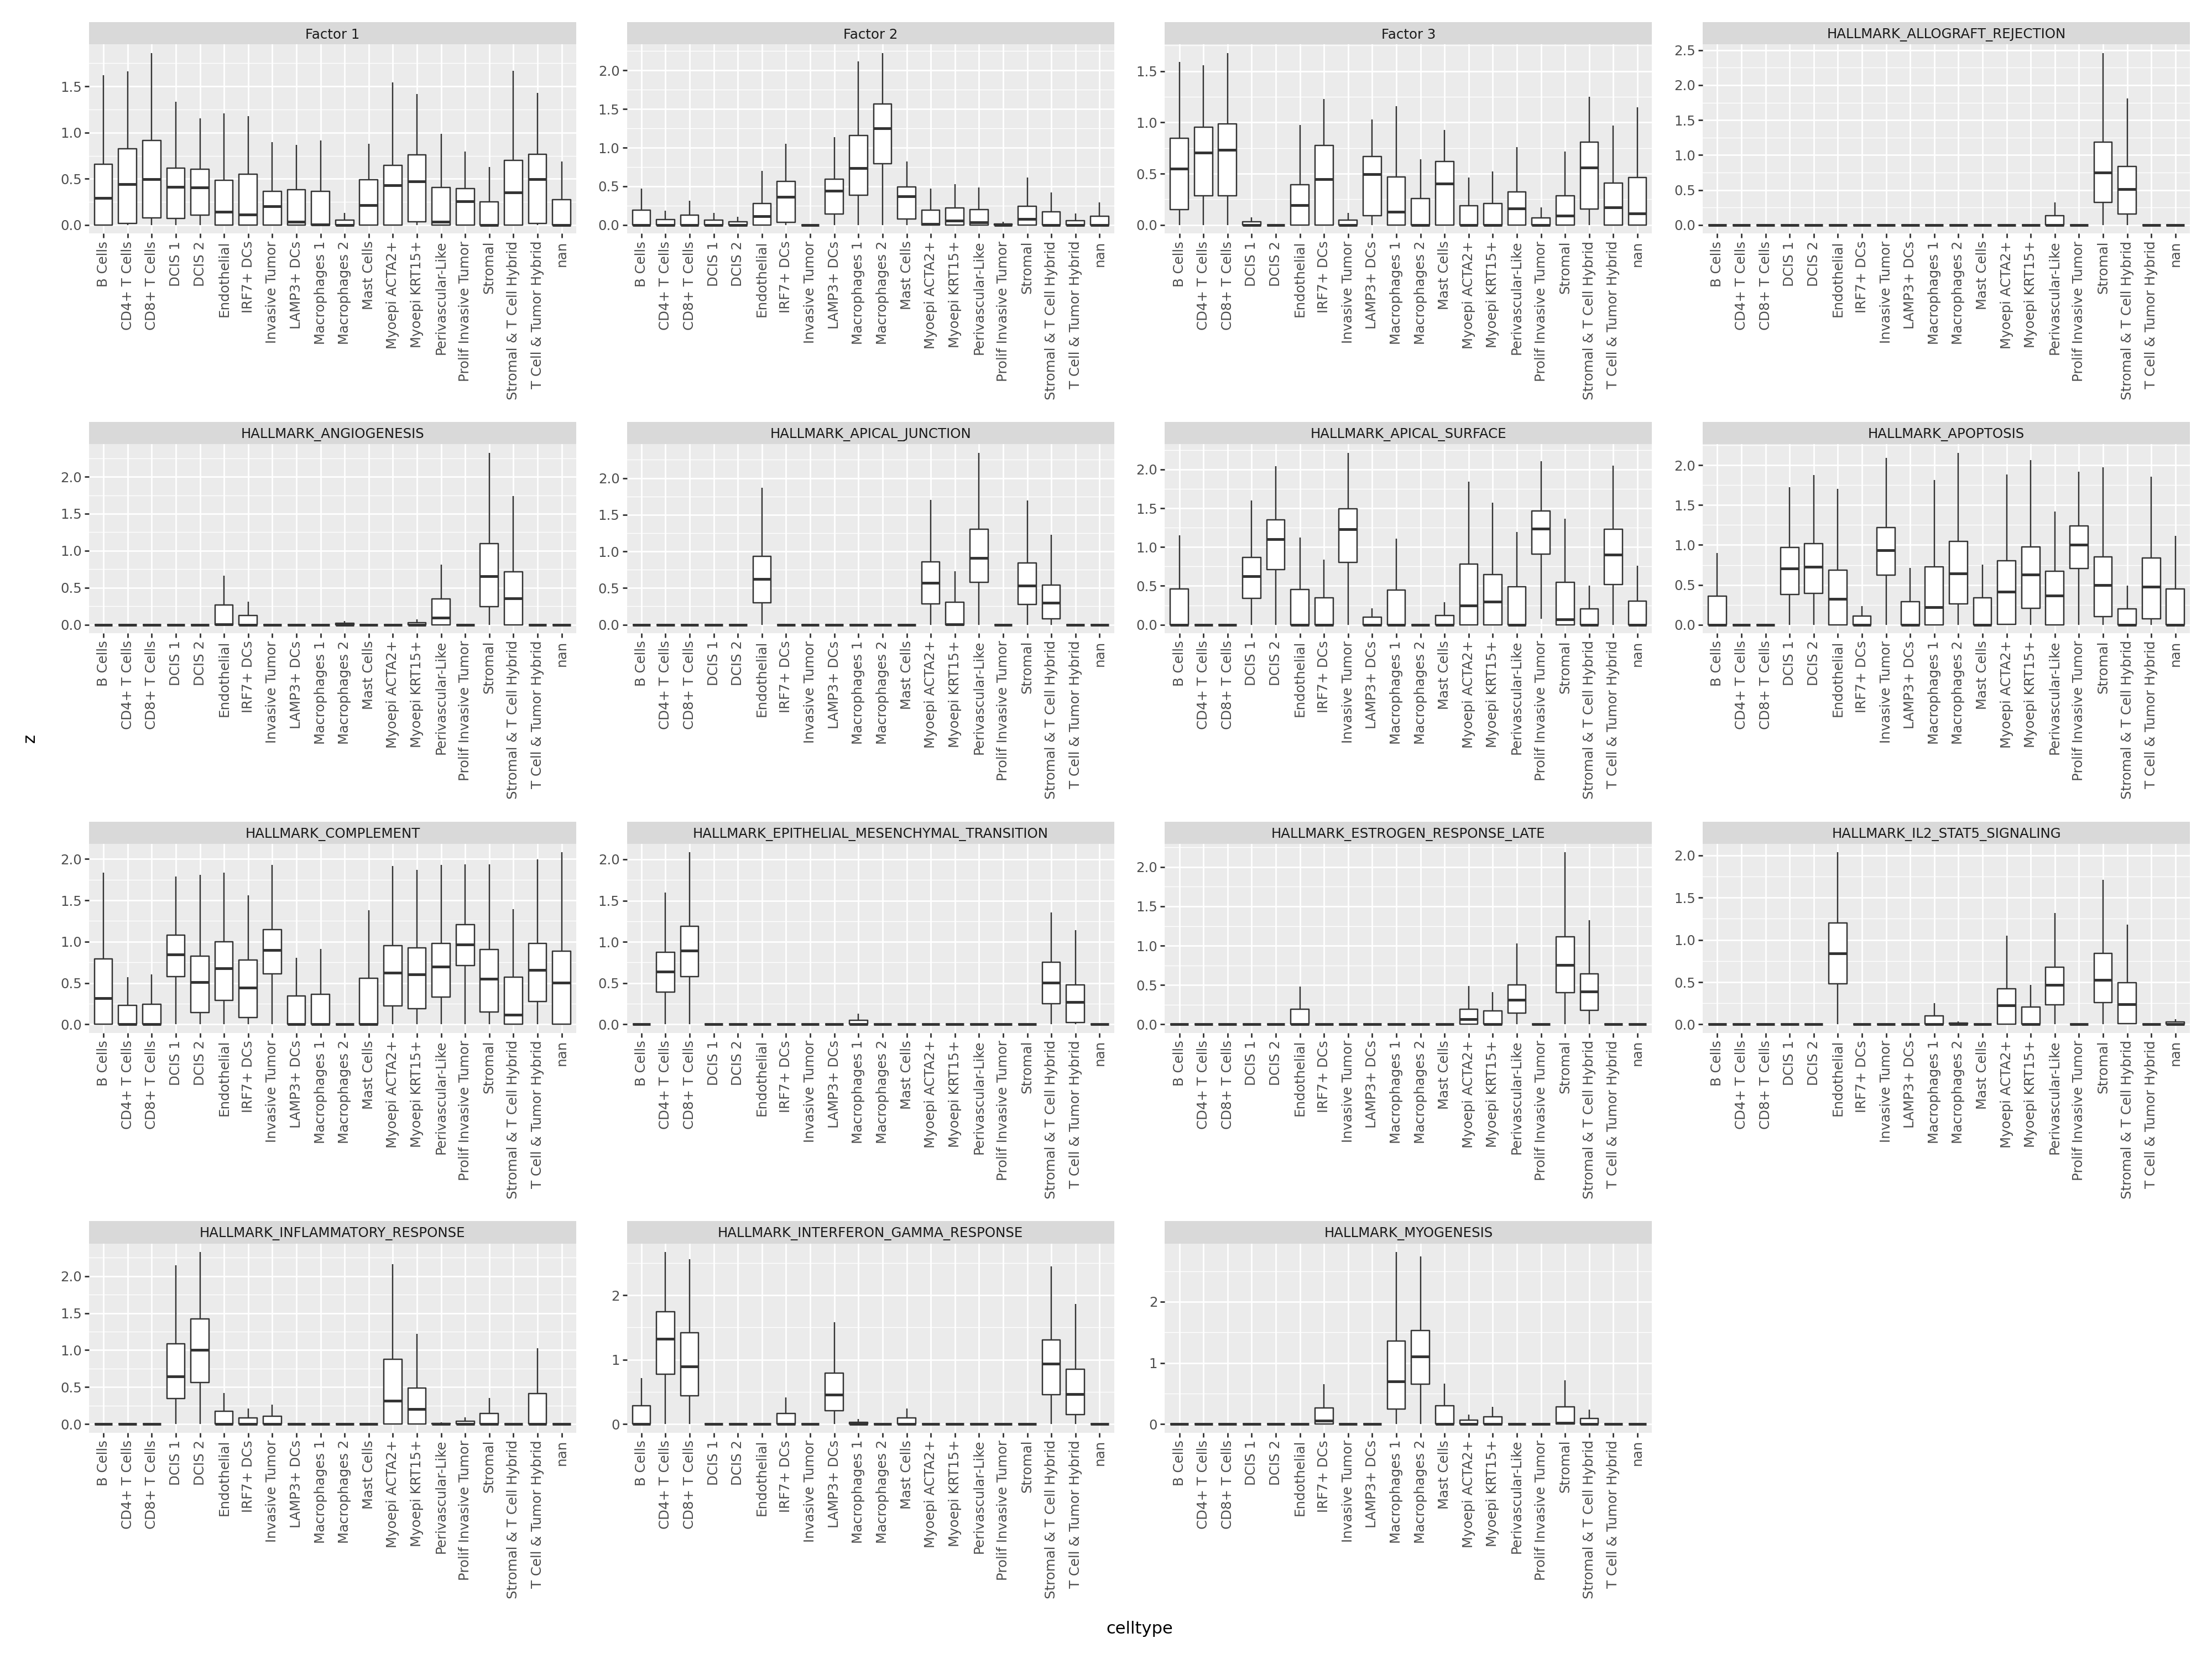

In [30]:
# DataFrame with all factors and factor naes
z_hallmark_chromium_df = pd.DataFrame(cache_hallmark["factors"].mean["group_chromium"].T, columns=cache_hallmark["factor_names"])

# Select top 15 factors wrt r2
z_hallmark_chromium_df = z_hallmark_chromium_df[df_r2_hallmark.index[:15]]

# add cell type information
z_hallmark_chromium_df["celltype"] = data["group_chromium"]["rna"].obs["celltype"].values

# melt dataframe for plotting
z_hallmark_chromium_df_long = z_hallmark_chromium_df.melt(id_vars="celltype", var_name="factor", value_name="z")

plot = (
    p9.ggplot(z_hallmark_chromium_df_long, p9.aes(x="celltype", y="z"))
    + p9.geom_boxplot(outlier_shape="")
    + p9.facet_wrap("~factor", scales="free")
    + p9.theme(figure_size=(20, 15), axis_text_x=p9.element_text(rotation=90))
)
plot.show()

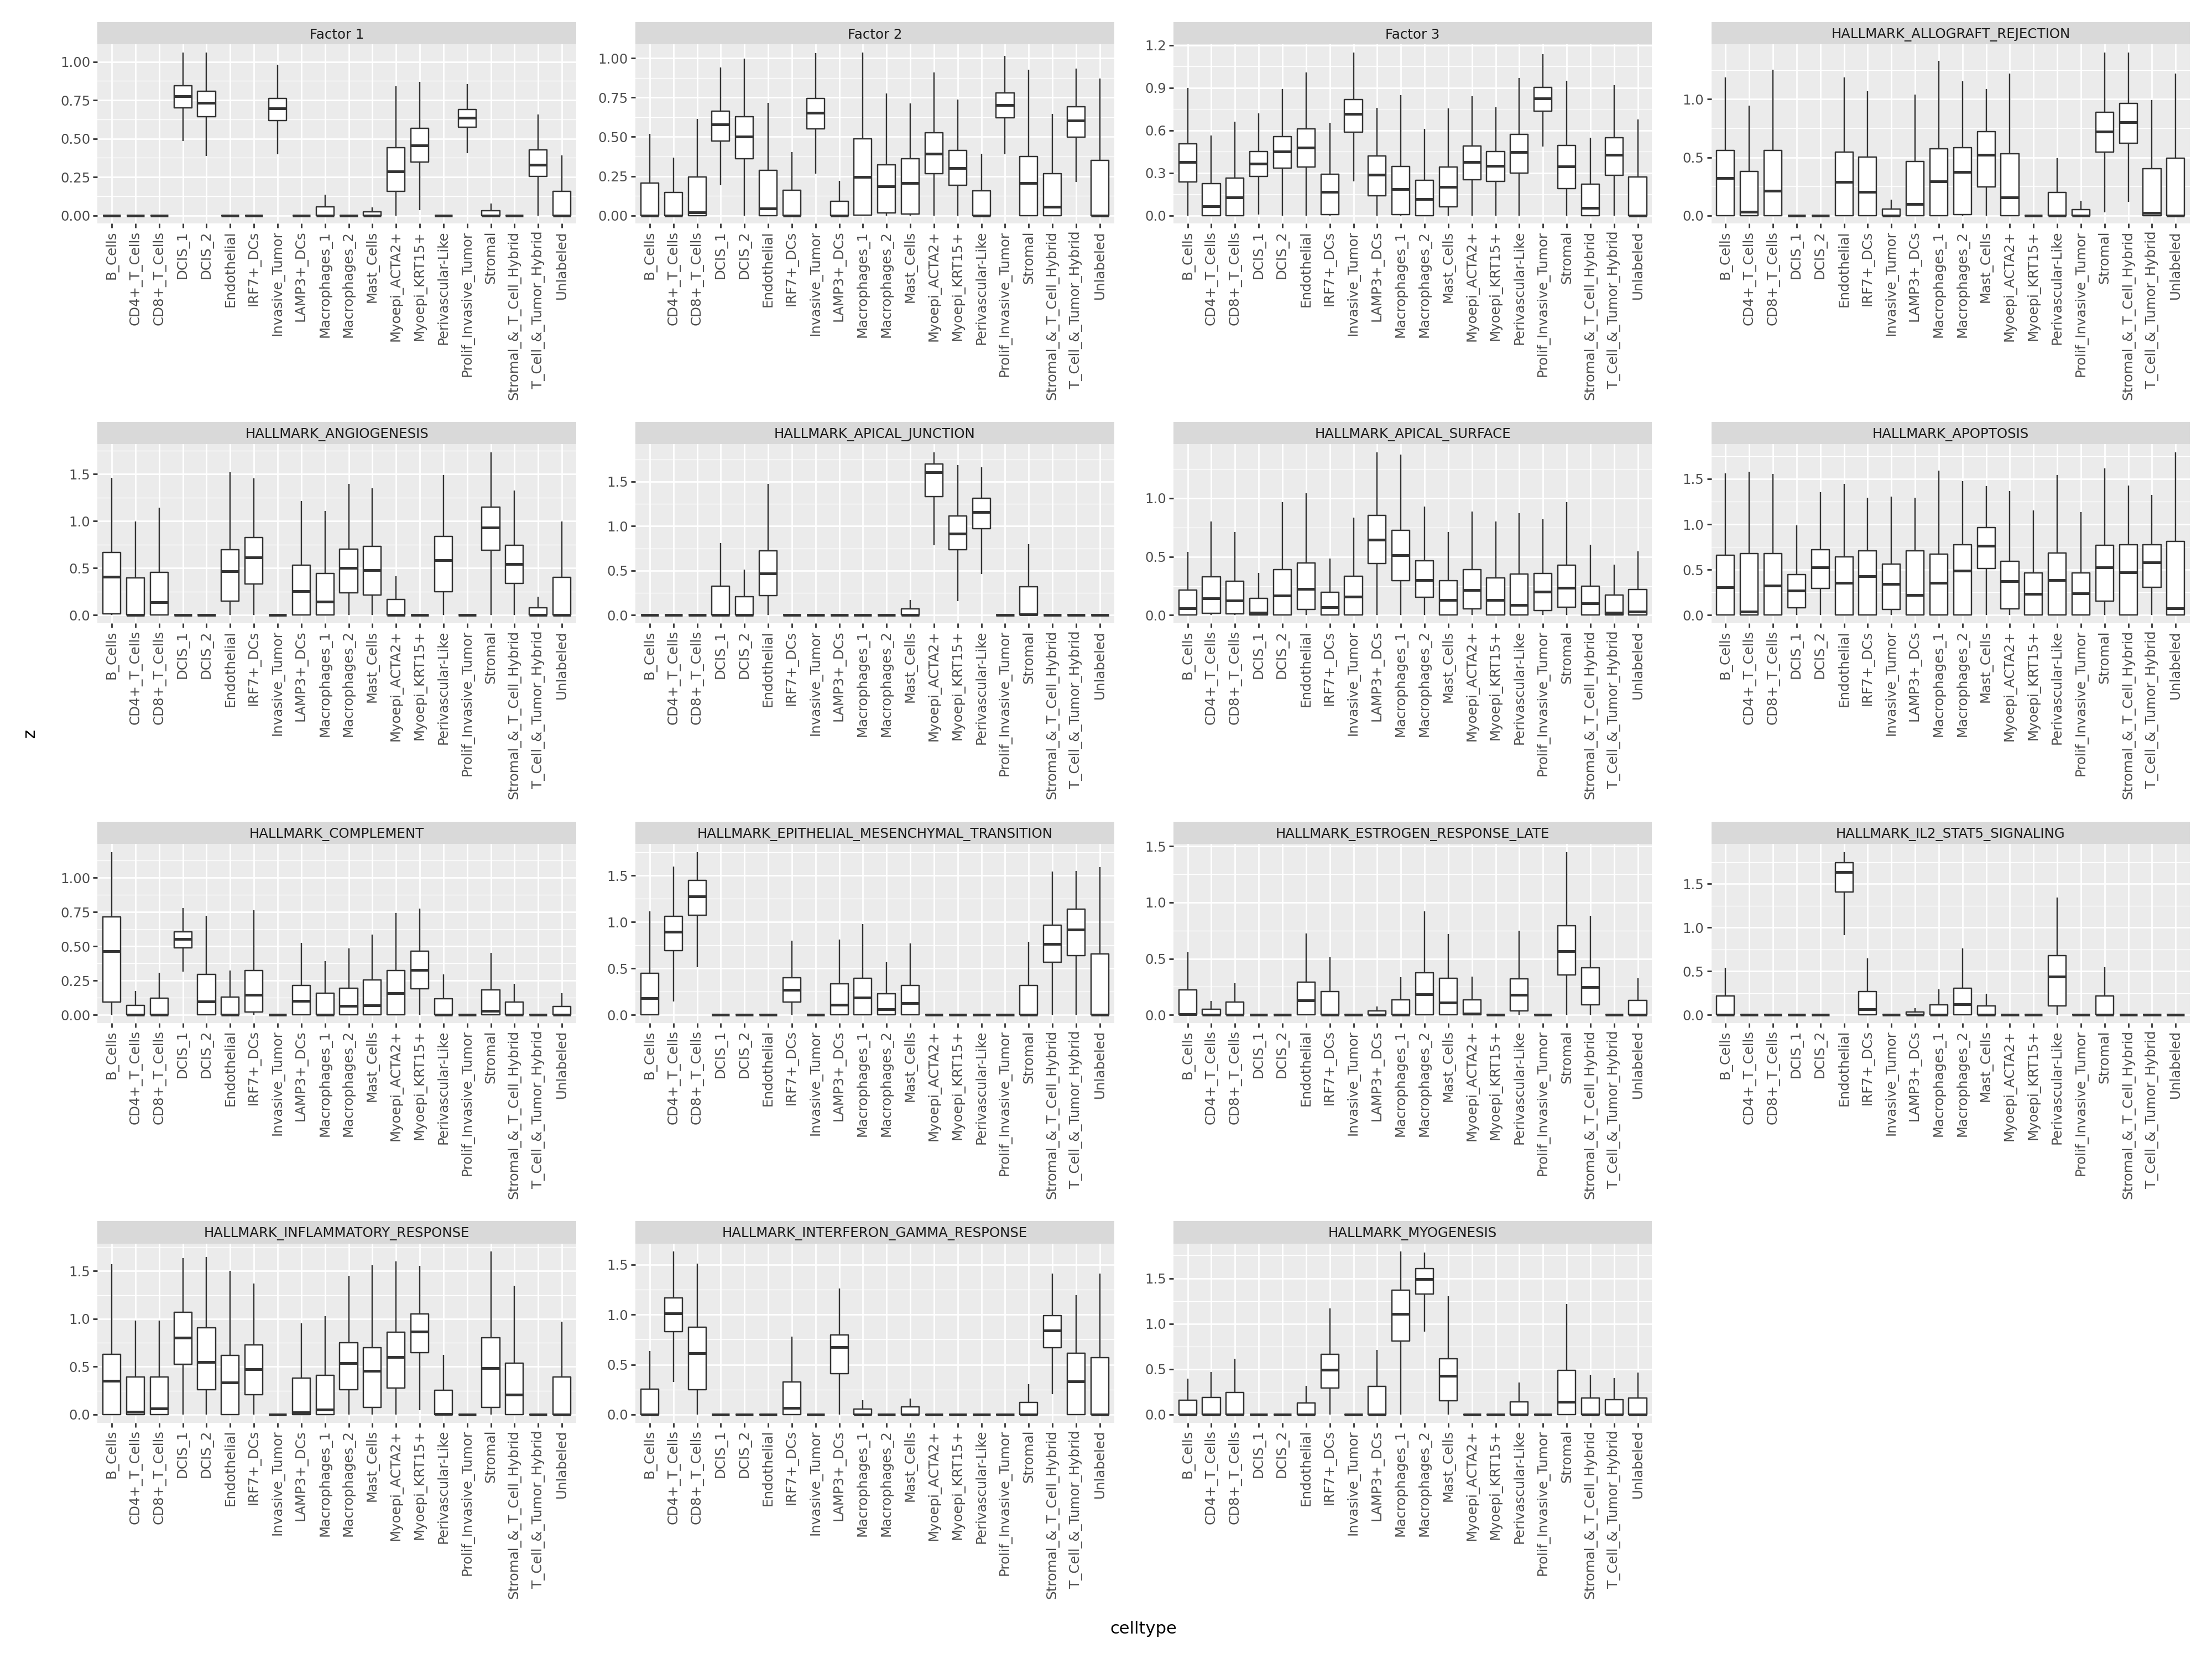

In [31]:
# DataFrame with all factors and factor naes
z_hallmark_xenium_df = pd.DataFrame(cache_hallmark["factors"].mean["group_xenium"].T, columns=cache_hallmark["factor_names"])

# Select top 15 factors wrt r2
z_hallmark_xenium_df = z_hallmark_xenium_df[df_r2_hallmark.index[:15]]

# add cell type information
z_hallmark_xenium_df["celltype"] = data["group_xenium"]["rna"].obs["celltype"].values

# melt dataframe for plotting
z_hallmark_xenium_df_long = z_hallmark_xenium_df.melt(id_vars="celltype", var_name="factor", value_name="z")

plot = (
    p9.ggplot(z_hallmark_xenium_df_long, p9.aes(x="celltype", y="z"))
    + p9.geom_boxplot(outlier_shape="")
    + p9.facet_wrap("~factor", scales="free")
    + p9.theme(figure_size=(20, 15), axis_text_x=p9.element_text(rotation=90))
)
plot.show()

## Top features per factor

In [60]:
def to_upper(feature_set_collection):
    return feature_sets.FeatureSets(
        [
            feature_sets.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )

# load annotations
gene_set_collection = to_upper(feature_sets.from_gmt(
    "../msigdb/c4.3ca.v2024.1.Hs.symbols.gmt", name="3ca"
))

gene_set_collection = gene_set_collection.filter(
    data["group_chromium"]["rna"].var_names,
    min_fraction=0.2,
    min_count=15,
    max_count=300,
)

data["group_chromium"]["rna"].varm["gene_set_mask"] = gene_set_collection.to_mask(
    data["group_chromium"]["rna"].var_names.tolist()
).T

In [72]:
data["group_chromium"]["rna"].varm["gene_set_mask"]

GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1  \
ISG15                                         False   
TNFRSF18                                      False   
TNFRSF4                                       False   
MXRA8                                         False   
VWA1                                          False   
...                                             ...   
MTCP1                                         False   
IL9R                                          False   
MT-ND1                                        False   
MT-CO2                                        False   
MT-ATP6                                       False   

          GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2  \
ISG15                                         False   
TNFRSF18                                      False   
TNFRSF4                                       False   
MXRA8                                         False   
VWA1                                          False   
...                                             ...   
MTCP1                                         False   
IL9R                                          False   
MT-ND1                                        False   
MT-CO2                                        False   
MT-ATP6                                       False   

          GAVISH_3CA_MALIGNANT_METAPROGRAM_14_EMT_3  \
ISG15                                          True   
TNFRSF18                                      False   
TNFRSF4                                       False   
MXRA8                                         False   
VWA1                                          False   
...                                             ...   
MTCP1                                         False   
IL9R                                          False   
MT-ND1                                        False   
MT-CO2                                        False   
MT-ATP6                                       False   

          GAVISH_3CA_MALIGNANT_METAPROGRAM_15_EMT_4  \
ISG15                                         False   
TNFRSF18                                      False   
TNFRSF4                                       False   
MXRA8                                         False   
VWA1                                          False   
...                                             ...   
MTCP1                                         False   
IL9R                                          False   
MT-ND1                                        False   
MT-CO2                                        False   
MT-ATP6                                       False   

          GAVISH_3CA_MALIGNANT_METAPROGRAM_16_MES_GLIOMA  \
ISG15                                              False   
TNFRSF18                                           False   
TNFRSF4                                            False   
MXRA8                                              False   
VWA1                                               False   
...                                                  ...   
MTCP1                                              False   
IL9R                                               False   
MT-ND1                                             False   
MT-CO2                                             False   
MT-ATP6                                            False   

          GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1  \
ISG15                                                  True         
TNFRSF18                                              False         
TNFRSF4                                               False         
MXRA8                                                 False         
VWA1                                                  False         
...                                                     ...         
MTCP1                                                 False         
IL9R                                                  False         
MT-ND1                  

In [8]:
data['group_xenium']['rna'].obs.index

Index(['1', '10', '100', '1000', '10000', '100000', '100001', '100002',
       '100003', '100004',
       ...
       '99990', '99991', '99992', '99993', '99994', '99995', '99996', '99997',
       '99998', '99999'],
      dtype='object', length=167780)

In [5]:
data['group_chromium']['rna']

AnnData object with n_obs × n_vars = 30365 × 2234
    obs: 'celltype'
    var: 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'